In [53]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from regions import CircleSkyRegion
from IPython.display import display
from gammapy.data import DataStore
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.datasets import MapDataset
from gammapy.makers.utils import make_theta_squared_table
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.estimators import FluxPointsEstimator #BKH

In [2]:
from gammapy.modeling.models import (
    FoVBackgroundModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.modeling import Fit

In [3]:
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_theta_squared_table

check_tutorials_setup()


System:

	python_executable      : /home/khelifi/anaconda3/envs/gammapy-dev/bin/python 
	python_version         : 3.8.13     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.1.dev40+g4016cc909 
	path                   : /home/khelifi/MesProgrammes/gammapy/gammapy 


Other packages:

	numpy                  : 1.22.4     
	scipy                  : 1.9.1      
	astropy                : 5.1        
	regions                : 0.6        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.5.0      
	jupyterlab             : 3.4.8      
	matplotlib             : 3.6.1      
	pandas                 : 1.5.0      
	healpy                 : 1.16.1     
	iminuit                : 2.17.0     
	sherpa                 : 4.15.0     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 2.2.1      


Gammapy environment variables

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/khelifi/MesProgrammes/gammapy-data/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [5]:
display(data_store.obs_table[["OBS_ID", "DATE-OBS", "RA_PNT", "DEC_PNT", "OBJECT"]])

OBS_ID,DATE-OBS,RA_PNT,DEC_PNT,OBJECT
,,deg,deg,
int64,bytes10,float32,float32,bytes18
20136,2004-03-26,228.6125,-58.771667,MSH15-52
20137,2004-03-26,228.6125,-59.771667,MSH15-52
20151,2004-03-27,228.6125,-58.771667,custom
20275,2004-04-14,187.27792,2.552389,3C 273
20282,2004-04-14,228.6125,-58.771667,MSH 15-5-02
20283,2004-04-15,228.6125,-59.771667,MSH 15-5-02
...,...,...,...,...
47802,2008-08-27,330.29538,-30.225555,PKS 2155-304


In [6]:
#observations = data_store.get_observations([47829, 47828, 47827])

In [7]:
obs_id = data_store.obs_table["OBS_ID"][data_store.obs_table["OBJECT"] == "PKS 2155-304"]

In [8]:
observations = data_store.get_observations(obs_id)
print("No. of observations: ", len(observations)) 

No. of observations:  21


In [9]:
#  print(observations)

In [10]:
observations.ids

['33787',
 '33788',
 '33789',
 '33790',
 '33791',
 '33792',
 '33793',
 '33794',
 '33795',
 '33796',
 '33797',
 '33798',
 '33799',
 '33800',
 '33801',
 '47802',
 '47803',
 '47804',
 '47827',
 '47828',
 '47829']

In [11]:
pks_position = SkyCoord(ra=329.71693826, dec=-30.225589, unit="deg", frame="icrs")

In [12]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pks_position.ra,
    lat=pks_position.dec,
    radius=5 * u.deg,
)

In [13]:
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 21


In [14]:
# Define an energy range
energy_true_min = 100 * u.GeV
energy_true_max = 30.0 * u.TeV
en_nbins_true = 40
energy_min = 200 * u.GeV
energy_max = 20.0 * u.TeV
en_nbins = 15
offset_max =  2.5 * u.deg

In [15]:
energy_axis_true_ltime = MapAxis.from_energy_bounds(
    energy_true_min, energy_true_max, nbin=1, unit="TeV", name="energy_true"
)

In [16]:
geom_true = WcsGeom.create(
    skydir=pks_position,
    binsz=0.02,
    width=(6, 6),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis_true_ltime],
)

In [17]:
livetime = Map.from_geom(geom_true, unit=u.hr)

In [18]:
# plt.figure()
# ax = livetime.plot(add_cbar=True)

In [19]:
for obs in observations:
    geom_obs = geom_true.cutout(position=obs.pointing_radec, width=2.0 * offset_max)
    exposure = MapDatasetMaker.make_exposure(geom=geom_obs, observation=obs)
    on_axis = obs.aeff.evaluate(
        offset=0.0 * u.deg, energy_true=geom_true.axes["energy_true"].center
    )
    on_axis = on_axis.reshape((on_axis.shape[0], 1, 1))
    lv_obs = exposure / on_axis
    livetime.stack(lv_obs)

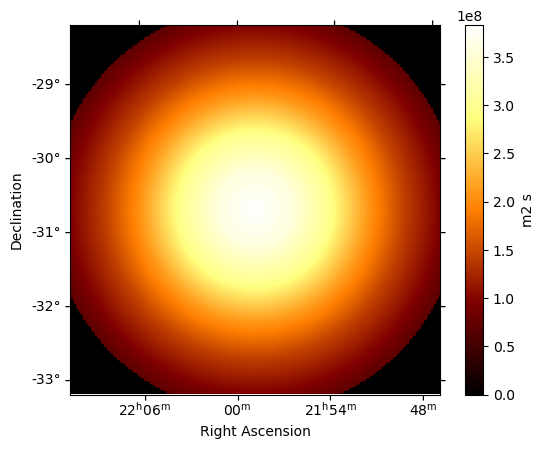

In [20]:
plt.figure()
ax = exposure.plot(add_cbar=True)

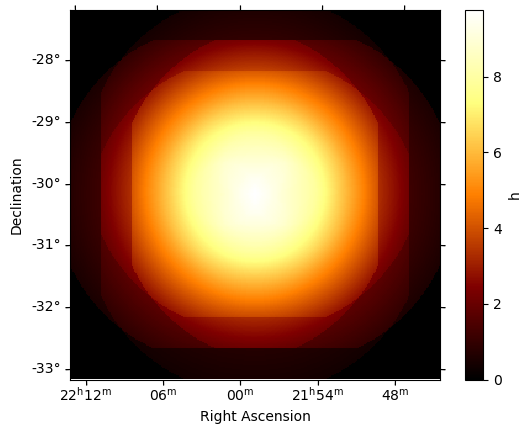

In [21]:
plt.figure()
ax = livetime.plot(add_cbar=True)

In [22]:
energy_axis = MapAxis.from_energy_bounds(
    energy_min, energy_max, nbin=en_nbins, unit="TeV", name="energy"
)

In [23]:
energy_axis_true = MapAxis.from_energy_bounds(
    energy_true_min, energy_true_max, nbin=en_nbins_true, unit="TeV", name="energy_true"
)

In [24]:
#BKH modif
geom = WcsGeom.create(
    skydir=pks_position,
    axes=[energy_axis],
    width=7 * u.deg,
    binsz=0.02 * u.deg,
    frame="icrs",
)

In [25]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="pks-stacked"
)

In [26]:
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-default"], offset_max=offset_max, #BKH modif
)

In [27]:
circle = CircleSkyRegion(center=pks_position, radius=0.3 * u.deg) #BKH modif (the offset is 0.5deg)
# exclusion_mask = ~geom.region_mask(regions=[circle])
exclusion_mask = geom.region_mask(regions=[circle], inside=False) #An other identical way
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [28]:
# exclusion_mask.plot_interactive()

In [29]:
for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} \
        - Obs Offset = {obs.pointing_radec.separation(geom.center_skydir):.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)
#     print(dataset)
#     dataset.peek()
#     dataset.edisp.peek()
#     dataset.psf.peek()
#     plt.figure()
#     dataset.mask_safe.sum_over_axes().plot()
#     break

print(stacked)

Background norm obs 33787: 1.07         - Obs Offset = 0.50 deg
Background norm obs 33788: 0.99         - Obs Offset = 0.50 deg
Background norm obs 33789: 1.06         - Obs Offset = 0.50 deg
Background norm obs 33790: 1.00         - Obs Offset = 0.50 deg
Background norm obs 33791: 1.04         - Obs Offset = 0.50 deg
Background norm obs 33792: 0.98         - Obs Offset = 0.50 deg
Background norm obs 33793: 1.04         - Obs Offset = 0.50 deg
Background norm obs 33794: 1.12         - Obs Offset = 0.50 deg
Background norm obs 33795: 1.08         - Obs Offset = 0.50 deg
Background norm obs 33796: 1.05         - Obs Offset = 0.50 deg
Background norm obs 33797: 0.96         - Obs Offset = 0.50 deg
Background norm obs 33798: 0.98         - Obs Offset = 0.50 deg
Background norm obs 33799: 1.01         - Obs Offset = 0.50 deg
Background norm obs 33800: 1.03         - Obs Offset = 0.50 deg
Background norm obs 33801: 0.92         - Obs Offset = 0.50 deg
Background norm obs 47802: 1.04         

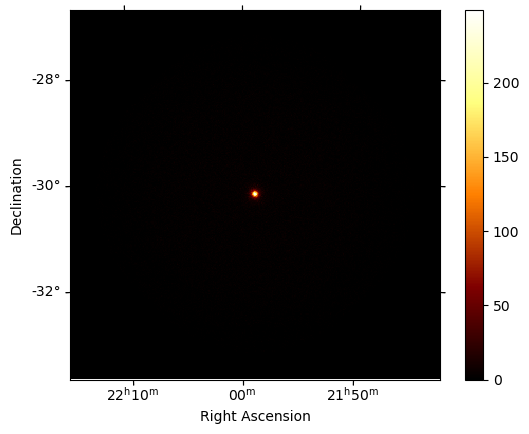

In [30]:
stacked.counts.sum_over_axes().plot(add_cbar=True);

In [31]:
# stacked.counts.sum_over_axes().smooth(0.05 * u.deg).plot(add_cbar=True);

In [32]:
# stacked.psf.peek()

In [33]:
spatial_model = PointSpatialModel(
    lon_0=pks_position.ra, lat_0=pks_position.dec, frame="icrs"
)
# BKH: one needs to add this to avoid nan
spatial_model.lon_0.min = pks_position.ra.value - 2
spatial_model.lon_0.max = pks_position.ra.value + 2
spectral_model = PowerLawSpectralModel(
    index=3.0, amplitude=1e-11 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name="pks2155")

bkg_model = FoVBackgroundModel(dataset_name=stacked.name) #This is a tiny trick to be sure of the dataset name

In [34]:
print(sky_model)

SkyModel

  Name                      : pks2155
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.000   +/-    0.00             
    amplitude                     :   1.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.717   +/-    0.00 deg         
    lat_0                         :    -30.226   +/-    0.00 deg         




In [35]:
print(spatial_model)

PointSpatialModel

  type   name    value    unit   error   ...    max    frozen is_norm link
------- ----- ----------- ---- --------- ... --------- ------ ------- ----
spatial lon_0  3.2972e+02  deg 0.000e+00 ... 3.317e+02  False   False     
spatial lat_0 -3.0226e+01  deg 0.000e+00 ... 9.000e+01  False   False     


In [36]:
stacked.models = [sky_model, bkg_model]

In [37]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (329.71693826, -33.18392464)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (329.71693826, -33.18392464)> is outside valid IRF map range, using nearest IRF defined within


In [38]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 218
	total stat : 350630.61

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [39]:
print(stacked)

MapDataset
----------

  Name                            : pks-stacked 

  Total counts                    : 65631 
  Total background counts         : 56223.30
  Total excess counts             : 9407.70

  Predicted counts                : 65631.34
  Predicted background counts     : 55940.61
  Predicted excess counts         : 9690.73

  Exposure min                    : 4.30e-03 m2 s
  Exposure max                    : 1.23e+10 m2 s

  Number of total bins            : 1837500 
  Number of fit bins              : 944912 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 350630.61

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : pks2155
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      i

**BKH add** (from https://docs.gammapy.org/dev/tutorials/starting/analysis_2.html)

In [40]:
print(stacked.models.to_parameters_table())

     model        type      name      value    ... frozen is_norm link
--------------- -------- --------- ----------- ... ------ ------- ----
        pks2155 spectral     index  3.6031e+00 ...  False   False     
        pks2155 spectral amplitude  5.7286e-11 ...  False    True     
        pks2155 spectral reference  1.0000e+00 ...   True   False     
        pks2155  spatial     lon_0  3.2972e+02 ...  False   False     
        pks2155  spatial     lat_0 -3.0223e+01 ...  False   False     
pks-stacked-bkg spectral      norm  9.9497e-01 ...  False    True     
pks-stacked-bkg spectral      tilt  0.0000e+00 ...   True   False     
pks-stacked-bkg spectral reference  1.0000e+00 ...   True   False     


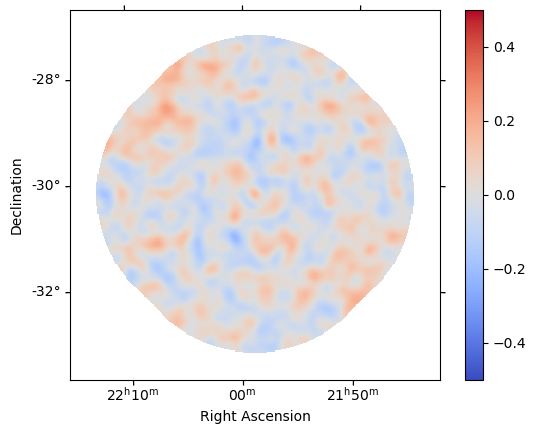

In [41]:
stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5);

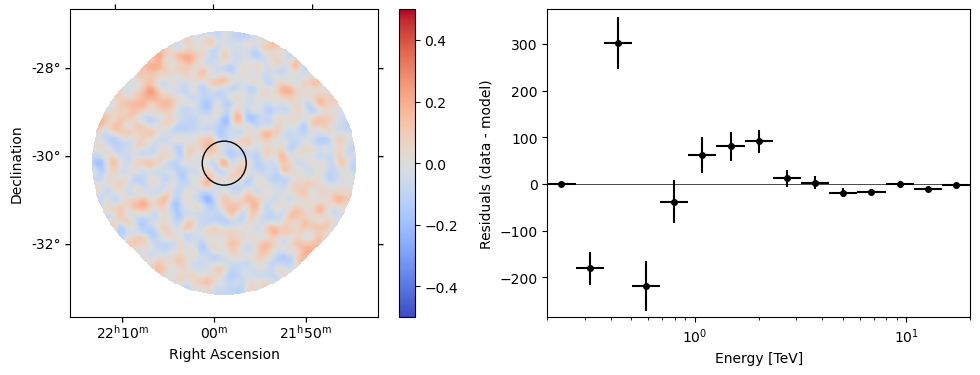

In [42]:
region = CircleSkyRegion(center=pks_position, radius=0.5 * u.deg)

stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

In [43]:
residuals = stacked.residuals(method="diff")
residuals.smooth("0.08 deg").plot_interactive(
    cmap="coolwarm", vmin=-0.2, vmax=0.2, stretch="linear", add_cbar=True
);

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [44]:
spec = sky_model.spectral_model

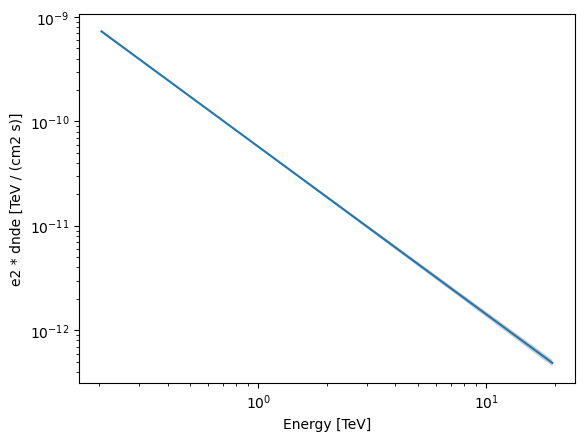

In [50]:
energy_bounds = [energy_min, energy_max] * u.TeV
spec.plot(energy_bounds=energy_bounds, energy_power=2)
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)

In [57]:
# energy_edges = [0.5, 0.75, 1, 2, 4, 6, 10] * u.TeV
energy_edges = np.exp(np.linspace(np.log(energy_min.to("TeV").value), np.log(energy_max.to("TeV").value), 7))*u.TeV
               
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="pks2155")

<AxesSubplot: xlabel='Energy [TeV]', ylabel='dnde [TeV / (cm2 s)]'>

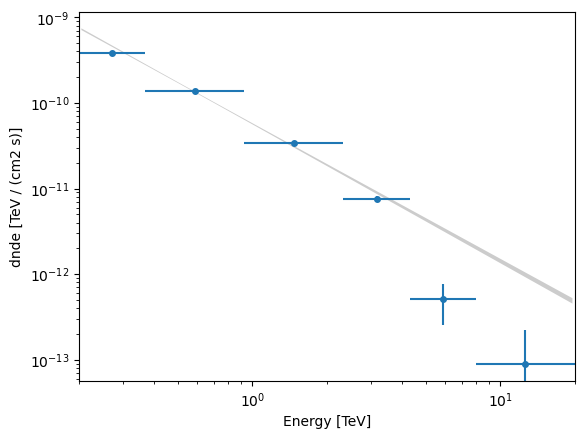

In [58]:
flux_points = fpe.run(datasets=[stacked])

ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2);
flux_points.plot(ax=ax, energy_power=2);